In [1]:
import tensorflow as tf
import cv2
from random import randint
import skimage.io
from skimage.color import rgb2gray
%run create_tfrecord.ipynb

In [2]:
SEQ_NUM_FRAMES = 64
CROP_SIZE = 128
BATCH_SIZE = 20
NUM_EPOCHS = 10000
tfrecords_dir = '/../../../../newvolume/samples_v4.0/*.tfrecords'

In [3]:
# Os métodos nessa célula não foram utilizados. Eles foram implementados, pois foi feita uma tentativa de alimentar o 
# gerados com frames ao invés de um espaço latente.

def get_frame_index_interval(num_frames):
    if num_frames == 64:
        return 0, 63
    middle_frame_index = randint(32, (num_frames-32)-1)
    start = middle_frame_index-32
    end = middle_frame_index+32
    assert start > -1
    assert end < num_frames
    assert end - start == 64
    return start, end 
    
def get_random_frame_index(num_frames):
    return randint(0, num_frames-1)

def get_batch_of_initial_frames(batch_videos, num_frames=64):
    ithvideo_ithframe = [ (get_random_frame_index(BATCH_SIZE), get_random_frame_index(num_frames))
                             for i in range(BATCH_SIZE) ]
    frames = [batch_videos[indexes[0]][indexes[1]] for indexes in ithvideo_ithframe]
    return tf.stack(frames)

In [4]:
get_frame_index_interval(96)

(1, 65)

In [5]:
def decode(serialized_example, sess):
    """ Decodifica um vídeo em um .tfrecord para uma sequência de frames(matrizes de escalares(pixels) em sequência) """
    features = dict()
    
    for i in range(SEQ_NUM_FRAMES):
        features["frames/{:04d}".format(i)] = tf.FixedLenFeature((), tf.string)
    
    parsed_features = tf.parse_single_example(serialized_example, features)
    
    frames = []
    for i in range(SEQ_NUM_FRAMES):
        frames.append(tf.image.decode_jpeg(parsed_features["frames/{:04d}".format(i)]))

    frames = tf.stack(frames)

    return frames

def preprocess(frames):
    """ Etapa de pré-processamento: Redimensiona, remove o RGB e normaliza os valores para o intervalo de [-1.0, 1.0]"""
    resized = tf.image.resize_images(frames, (256, 256))
    frames_list = [tf.image.rgb_to_grayscale(frame) for frame in tf.unstack(resized)]
    frames = tf.cast(tf.stack(frames_list), tf.float32) * (1./127.5) - 1
    
    return tf.stack(frames)

In [6]:
tfrecords = tf.gfile.Glob(tfrecords_dir) # pega os paths para todos os arquivos .tfrecords
len(tfrecords)

22

In [7]:
# configura a sessão do Tensorflow
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
sess.run(init_op)

In [8]:
# configura e cria a instância do Dataset que será utilizado para alimentar o modelo
dataset = tf.data.TFRecordDataset(tfrecords)
dataset = dataset.repeat(NUM_EPOCHS)
dataset = dataset.map(lambda x: decode(x, sess))
dataset = dataset.map(preprocess)
dataset = dataset.batch(BATCH_SIZE)

In [9]:
iterator = dataset.make_one_shot_iterator()
next_batch = iterator.get_next()

In [11]:
# num, bins = np.histogram(frames[0])
# plt.bar(bins[:-1], num)
# plt.show()

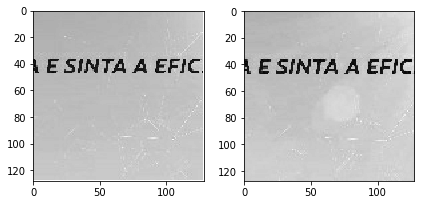

In [30]:
# show_sample(batch_videos[0][0].reshape((128,128)), batch_videos[0][1].reshape((128,128)))
# for frame in batch_videos[0]:
#     plt.imshow(frame)
#     plt.show()

In [13]:
# for i in range(NUM_EPOCHS):
#     batch_videos = sess.run(next_batch)
#     print(get_batch_of_initial_frames(batch_videos).shape)

In [14]:
# show_sample(batch_videos[0][0], batch_videos[15][5], xlim=128, ylim=128)

In [15]:
# print(batch_videos[0][0][0,0:4])
# print(batch_videos[0][0].shape)

In [16]:
# standardized_frames = standardize(batch_videos[0])
# print(standardized_frames.shape)
# print(standardized_frames[0])

In [17]:
# resized_frame = tf.cast(resized_frame * (1./255.) - 0.5, tf.float32)
# print(resized_frame.shape)
# print(resized_frame)

In [18]:
#     show_sample(resized_frame.eval(), tf.reshape(standardized_frames[63], (128, 128, 3)), xlim=16, ylim=16)

In [25]:
import matplotlib.pyplot as plt

def show_sample(img1, img2, nrows=1, ncols=2, xlim=256, ylim=256):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    ax = axes.ravel()
    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2, cmap='gray')
    ax[0].set_xlim(0, xlim)
    ax[0].set_ylim(ylim, 0)
    plt.tight_layout()
    plt.show()   

In [20]:
# for i in range(BATCH_SIZE):
#     show_sample(batch_videos[i][0], batch_videos[i][63])